# Spectrogram Modelling

## For Team Guardians (Capstone)

By Brandon Low

In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import glob
# !pip install opencv-python  # to use cv2 library
import cv2

## Data preprocessing

In [3]:
# Importing Spectrogram data from folders (in Vertex AI JupyterLab)
walk_spectr = [cv2.imread(file) for file in glob.glob("/home/jupyter/Activities/A1 - Walking/*.png")]
sit_spectr = [cv2.imread(file) for file in glob.glob("/home/jupyter/Activities/A2 - Sitting/*.png")]
stand_spectr = [cv2.imread(file) for file in glob.glob("/home/jupyter/Activities/A3 - Standing/*.png")]
pickup_spectr = [cv2.imread(file) for file in glob.glob("/home/jupyter/Activities/A4 - Picking up/*.png")]

In [4]:
# Converting spectrograms into arrays (needed because of the way I read the data)
walk_spectr = np.array(walk_spectr)
sit_spectr = np.array(sit_spectr)
stand_spectr = np.array(stand_spectr)
pickup_spectr = np.array(pickup_spectr)

In [5]:
# Creating labels for the spectrogram classes
walk_labels = np.full((1, len(walk_spectr)), 0)
sit_labels = np.full((1, len(sit_spectr)), 1)
stand_labels = np.full((1, len(stand_spectr)), 2)
pickup_labels = np.full((1, len(pickup_spectr)), 3)

In [2]:
# Creating a dictionary for the class labels of the dataset
class_names_dict = {
    0: 'Walking',
    1: 'Sitting',
    2: 'Standing',
    3: 'Pick up'
}
# This was to enable easy identification of the predicted class.

In [ ]:
# Combining the different spectrogram classes and labels
spectr_combined = tf.concat([walk_spectr, sit_spectr, stand_spectr, pickup_spectr], 0)
labels_combined = np.hstack((walk_labels, sit_labels, stand_labels, pickup_labels))
labels_combined = labels_combined.reshape(-1)

In [8]:
# Shuffling the inputs and labels (so model learns all the classes)
tf.random.set_seed(1234)
spetr_sf = tf.random.shuffle(spectr_combined, seed=1)
labels_sf = tf.random.shuffle(labels_combined, seed=1)

In [9]:
# Split into train, test and validation (70-15-15 split)
dataset_size = len(spetr_sf)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)

X_train = spetr_sf[:train_size]
y_train = labels_sf[:train_size]
X_val = spetr_sf[train_size:train_size+val_size]
y_val = labels_sf[train_size:train_size+val_size]
X_test = spetr_sf[train_size+val_size:]
y_test = labels_sf[train_size+val_size:]

In [10]:
# Saving the datasets (so when I re-enter JupyterLab, I do not have to create/split the datasets again)
np.savez('ds_train', inputs=X_train, targets=y_train)
np.savez('ds_val', inputs=X_val, targets=y_val)
np.savez('ds_test', inputs=X_test, targets=y_test)

In [3]:
# Loading the saved datasets
npz = np.load('ds_train.npz')
X_train = npz['inputs']
y_train = npz['targets']

npz = np.load('ds_val.npz')
X_val = npz['inputs']
y_val = npz['targets']

npz = np.load('ds_test.npz')
X_test = npz['inputs']
y_test = npz['targets']

In [ ]:
# Transforming the datasets into tensors (makes it easier to create data pipeline)
spectr_train = tf.data.Dataset.from_tensor_slices({"spectrogram": X_train, "label": y_train})
spectr_val = tf.data.Dataset.from_tensor_slices({"spectrogram": X_val, "label": y_val})
spectr_test = tf.data.Dataset.from_tensor_slices({"spectrogram": X_test, "label": y_test})

In [14]:
# Seeing the type specification of an element of the train set.
spectr_train.element_spec

{'spectrogram': TensorSpec(shape=(558, 1130, 3), dtype=tf.uint8, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [6]:
# Scaling the datasets to enable more efficient computation (with large integers for colours, it requires longer computation time)
def scale(dataset):
    spectrogram, label = dataset["spectrogram"], dataset["label"]
    scaled_data = spectrogram/255
    return scaled_data, label

scaled_train = spectr_train.map(scale)
scaled_val = spectr_val.map(scale)
scaled_test = spectr_test.map(scale)

In [7]:
# Checking the type specification of an element of the scaled train set.
scaled_train.element_spec

(TensorSpec(shape=(558, 1130, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [18]:
# Seeing the class distribution of the validation set
ds_labels = []
for i, j in scaled_val:
    ds_labels.append(j.numpy())
uniq_label = np.unique(ds_labels)

print("Dataset counts in validation set:")

for i in uniq_label:
    print(class_names_dict[i], ds_labels.count(i))

Dataset counts in validation set:
Walking 6
Sitting 7
Standing 9
Pick up 6


Walking, Sitting and Standing should contain the same amount of samples. But the shuffling means that that is not the case.

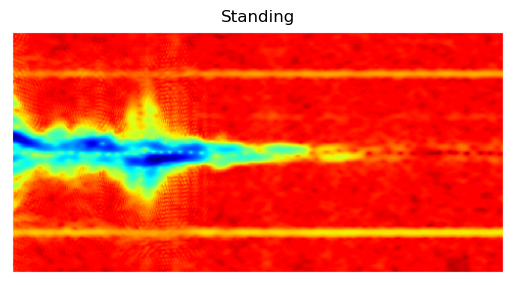

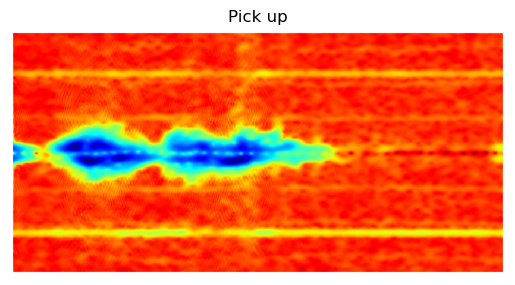

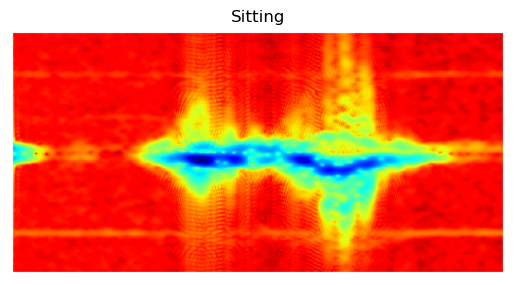

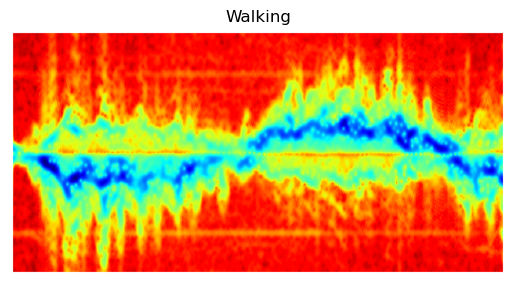

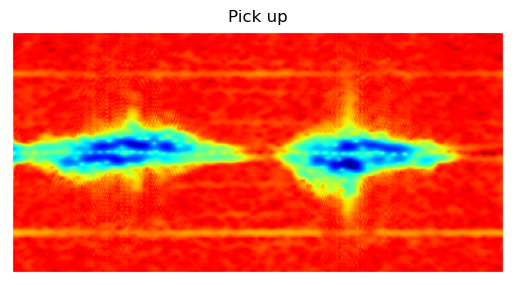

In [8]:
# Visualising 5 images in the train set
def show(spectrogram, label):
    plt.figure()
    plt.imshow(spectrogram)
    plt.title(label)
    plt.axis('off')

for spectrogram, label in scaled_train.take(5):
    show(spectrogram, class_names_dict[label.numpy()])

Note: The colours have changed from the original spectrograms due to scaling.

In [14]:
# Augmenting train dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE_length = 279
IMAGE_SIZE_width = 565
# These are half of the length and width

def augment(spectrogram, label):
    spectrogram = tf.image.convert_image_dtype(spectrogram, tf.float32)
    spectrogram = tf.image.random_flip_left_right(spectrogram)
    spectrogram = tf.image.resize(spectrogram, (IMAGE_SIZE_length, IMAGE_SIZE_width))
    spectrogram = tf.image.resize_with_pad(spectrogram, IMAGE_SIZE_length + 6, IMAGE_SIZE_width + 6)
    spectrogram = tf.image.random_crop(spectrogram, size=[IMAGE_SIZE_length, IMAGE_SIZE_width, 3])
    return spectrogram, label

# Resizing the spectrogram data to have dimensions of (279, 565, 3) and creating batches
def pre_process_spectrogram(spectrogram, label):
    spectrogram = tf.image.convert_image_dtype(spectrogram, tf.float32)
    spectrogram = tf.image.resize(spectrogram, (IMAGE_SIZE_length, IMAGE_SIZE_width))
    return spectrogram, label

TRAIN_BATCH_SIZE = 32
# train_batches = scaled_train.map(pre_process_spectrogram).batch(TRAIN_BATCH_SIZE).cache().repeat()  # for model_1
train_batches = scaled_train.cache().map(augment, num_parallel_calls=AUTOTUNE).batch(TRAIN_BATCH_SIZE).repeat().prefetch(AUTOTUNE)  # for model_2
validation_batches = scaled_val.map(pre_process_spectrogram).batch(TRAIN_BATCH_SIZE).cache().repeat()

## Modelling

In [10]:
# Importing relevant TensorFlow packages for model building
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [11]:
# Importing ResNet50 model from TensorFlow and using architecture to create a new model.
from tensorflow.keras.applications.resnet50 import ResNet50

def create_model():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(279, 565, 3))
    inputs = layers.Input(shape=(279, 565, 3))
    resnet = base_model(inputs)
    flattening = layers.Flatten()(resnet)
    dense_layer = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(flattening)
    dropout = layers.Dropout(0.2)(dense_layer)
    outputs = layers.Dense(len(class_names_dict), kernel_initializer='he_uniform')(dropout)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

optimised_model = create_model()
optimised_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 279, 565, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 9, 18, 2048)       23587712  
                                                                 
 flatten (Flatten)           (None, 331776)            0         
                                                                 
 dense (Dense)               (None, 256)               84934912  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 108,523,652
Trainable params: 108,470,532
Non-t

In [12]:
# Training model on spectrogram dataset
optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.1)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimised_model.compile(optimizer=optimiser, loss=loss_fn,
                       metrics=['accuracy'])

patience_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=3, min_lr=1e-5, verbose=1)

checkpoint_filepath = '/home/jupyter/model_2.h5'
    # model_1: no data augmentation
    # model_2: data augmentation
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

optimised_history = optimised_model.fit(
    train_batches,
    steps_per_epoch=100,
    epochs=120,
    validation_data=validation_batches,
    validation_steps=60,
    callbacks = [patience_callback, reduce_lr, model_checkpoint_callback]
)

Epoch 1/120


2022-11-30 05:33:15.392618: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


100/100 [==============================] - 130s 1s/step - loss: 2.0693 - accuracy: 0.9250 - val_loss: 2.2701 - val_accuracy: 0.3214 - lr: 1.0000e-04
Epoch 2/120
100/100 [==============================] - 107s 1s/step - loss: 8.5882e-05 - accuracy: 1.0000 - val_loss: 3.1875 - val_accuracy: 0.2143 - lr: 1.0000e-04
Epoch 3/120
100/100 [==============================] - 107s 1s/step - loss: 2.0404e-06 - accuracy: 1.0000 - val_loss: 0.2463 - val_accuracy: 0.9643 - lr: 6.4000e-05
Epoch 16/120
100/100 [==============================] - ETA: 0s - loss: 3.6597e-06 - accuracy: 1.0000
Epoch 16: ReduceLROnPlateau reducing learning rate to 5.119999987073243e-05.
100/100 [==============================] - 107s 1s/step - loss: 3.6597e-06 - accuracy: 1.0000 - val_loss: 0.2364 - val_accuracy: 0.9643 - lr: 6.4000e-05
Epoch 17/120
100/100 [==============================] - 107s 1s/step - loss: 4.2015e-07 - accuracy: 1.0000 - val_loss: 0.2397 - val_accuracy: 0.9643 - lr: 3.2768e-05
Epoch 25/120
100/100 [=

In [28]:
# Loading best model from training
model_1 = models.load_model('model_1.h5')
model_1.evaluate(scaled_test.map(pre_process_spectrogram).batch(TRAIN_BATCH_SIZE))

1/1 [==============================] - 3s 3s/step - loss: 0.3526 - accuracy: 0.8667


[0.35258257389068604, 0.8666666746139526]

In [13]:
# Loading best model from training
model_2 = models.load_model('model_2.h5')
model_2.evaluate(scaled_test.map(pre_process_spectrogram).batch(TRAIN_BATCH_SIZE))

1/1 [==============================] - 3s 3s/step - loss: 0.1311 - accuracy: 0.9333


[0.1310989111661911, 0.9333333373069763]

In [16]:
# Resizing the model test inputs and using model to predict on test data
AUTOTUNE = tf.data.experimental.AUTOTUNE
preprocessed_test = scaled_test.map(pre_process_spectrogram)
test_batch = preprocessed_test.batch(32).prefetch(buffer_size=AUTOTUNE)

probability_model = tf.keras.Sequential([
    # model_1, 
    model_2,
    tf.keras.layers.Softmax()
])

pred_class_mod = probability_model.predict(test_batch)

In [17]:
# Collecting new predictions
preds_collect = []
for line in range(len(pred_class_mod)):
    preds = np.argmax(pred_class_mod[line])
    preds_collect.append(preds)
preds_collect = np.array(preds_collect)

              precision    recall  f1-score   support

     Walking       1.00      1.00      1.00         7
     Sitting       0.89      0.89      0.89         9
    Standing       1.00      1.00      1.00         8
     Pick up       0.83      0.83      0.83         6

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



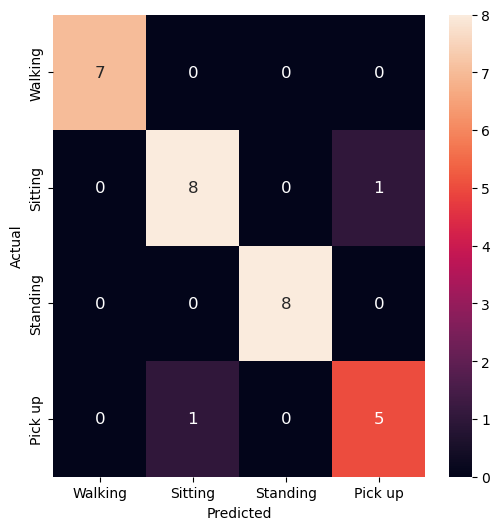

In [18]:
# Plotting the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(predictions, test_labels):
    cm=confusion_matrix(test_labels, predictions)
    cr=classification_report(test_labels, predictions,
                                target_names=[class_names_dict[i] for i in range(len(class_names_dict))])
    print(cr)
    plt.figure(figsize=(6,6))
    sns_hmp=sns.heatmap(cm, annot=True, annot_kws={"fontsize":12}, 
                        xticklabels = [class_names_dict[i] for i in range(len(class_names_dict))],
                        yticklabels = [class_names_dict[i] for i in range(len(class_names_dict))], fmt="d")
    sns_hmp.set(xlabel='Predicted', ylabel='Actual')
    fig = sns_hmp.get_figure()

plot_confusion_matrix(preds_collect, y_test)

The model predicts quite well with only 2 out of 30 misclassifications.